In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import importlib
import pickle
import sys
import os
import re
import seaborn as sns
from os.path import join as pjoin

import catrace.exp_collection as ecl
import catrace.process_time_trace as ptt
import catrace.plot_trace as pltr
import catrace.pattern_correlation as catpcr

from catrace.dataset import load_dataset_config



In [6]:
ob_config_file = '../dataset_configs/juvenile_dataset_OB.json'
dp_config_file = '../dataset_configs/juvenile_dataset.json'

from analysis_config import juvenile_window_name_to_frames
window_name = 'time_window_3s'
# window_name = 'time_window_5s'
# window_name = 'time_window_7s'
window = juvenile_window_name_to_frames[window_name]
print(window_name, window)
window_tag = f'window_{window[0]}to{window[1]}'
metric = 'pattern_correlation'
# metric = 'cosine'

fig_dir = f'../figures/juvenile/{window_name}/trial_to_trial_boxplot'
os.makedirs(fig_dir, exist_ok=True)

time_window_3s [38, 63]


In [7]:
import numpy as np
import pandas as pd

def extract_upper_triangle_similarities(simdf):
    """
    Extracts the upper triangle (excluding the diagonal) of similarity matrices
    grouped by the 'odor' level from a DataFrame with a MultiIndex.
    
    Parameters:
    simdf (pd.DataFrame): A DataFrame containing similarity matrices with a MultiIndex 
                          that has levels 'odor' and 'trial' in both the index and columns.
    
    Returns:
    pd.DataFrame: A DataFrame containing the 'odor' and the corresponding similarity values 
                  from the upper triangle of the matrices.
    """
    
    # Initialize an empty list to store the results
    results = []

    # Iterate over each group by the 'odor' level in the index
    for name, group in simdf.groupby(level='odor', observed=True):
        # Extract the values of the similarity matrix
        values = group.values
        
        # Get the upper triangle of the matrix, excluding the diagonal
        upper_triangle = values[np.triu_indices(values.shape[0], k=1)]
        
        # Create a DataFrame with the results and add the 'odor' name
        upper_triangle_df = pd.DataFrame({
            'odor': name,
            'similarity_values': upper_triangle
        })
        
        upper_triangle_df.set_index('odor', inplace=True)
        # Append the DataFrame to the results list
        results.append(upper_triangle_df.T)

    # Concatenate all results into a single DataFrame
    final_df = pd.concat(results, axis=1)
    
    return final_df

In [8]:
import os
from catrace.run.run_pattern_similarity import read_mats_from_dir

def get_cross_trial_df(config_file):
    dsconfig = load_dataset_config(config_file)
    sim_dir = os.path.join(dsconfig.processed_trace_dir, metric, window_tag)
    simdf_list, exp_cond_list = read_mats_from_dir(sim_dir, dsconfig.exp_list)
    final_df_list = []
    for idx, simdf in enumerate(simdf_list):
        final_df = extract_upper_triangle_similarities(simdf)
        final_df_list.append(final_df)
    cross_trial_df = pd.concat(final_df_list, keys=dsconfig.exp_list, names=['fish_id', 'cond'])
    cross_trial_df.index = cross_trial_df.index.droplevel(-1)
    return cross_trial_df

cross_trial_df_ob = get_cross_trial_df(ob_config_file)
cross_trial_df_dp = get_cross_trial_df(dp_config_file)

region_dfs = [cross_trial_df_ob, cross_trial_df_dp]

cross_trial_dff = pd.concat(region_dfs, keys=['OB', 'Dp'], names=['region', 'fish_id', 'cond'])


2021-07-15-DpOBEM-N2_OB None
2021-07-16-DpOBEM-N3_OB None
2021-12-10-DpOBEM-N4_OB None
2021-12-31-DpOBEM-N7_OB None
2022-02-13-DpOBEM-N10_OB None
2022-02-20-DpOBEM-N11_OB None
2021-02-05-DpOBEM-JH9_OB None
2021-03-18-DpOBEM-JH10_OB None
2021-03-19-DpOBEM-JH10_OB None
2021-04-02-DpOBEM-JH11_OB None
2021-04-03-DpOBEM-JH11_OB None
2021-05-01-DpOBEM-JH13_OB None
2021-05-22-DpOBEM-JH14_OB None
2021-09-15-DpOBEM-JH20_OB None
2021-09-17-DpOBEM-JH20_OB None
2021-09-18-DpOBEM-JH20_OB None
2021-07-30-DpOBEM-JH17_OB None
2021-07-31-DpOBEM-JH17_OB None
2021-09-02-DpOBEM-JH18_OB None
2021-09-03-DpOBEM-JH18_OB None
2021-09-04-DpOBEM-JH18_OB None
2021-09-29-DpOBEM-JH21_OB None
2021-10-01-DpOBEM-JH21_OB None
2021-10-02-DpOBEM-JH21_OB None
2021-10-14-DpOBEM-JH22_OB None
2021-11-10-DpOBEM-JH23_OB None
2021-11-11-DpOBEM-JH23_OB None
2021-11-14-DpOBEM-JH23_OB None
2021-11-24-DpOBEM-JH24_OB None
2021-11-27-DpOBEM-JH24_OB None
2021-11-26-DpOBEM-JH24_OB None
2021-07-15-DpOBEM-N2_Dp None
2021-07-16-DpOBEM-N3_

In [9]:
from scipy import stats

# Filter out naive fish
df_filtered = cross_trial_dff.xs('naive', level='cond')
# Filter so that fish_id is not in exp_14mm
#df_filtered = df_filtered[~df_filtered.index.get_level_values('fish_id').isin(exp_14mm)]
# Compare values from OB to values from Dp
df_dp = df_filtered.xs('Dp', level='region')
df_ob = df_filtered.xs('OB', level='region')

# Flatten the DataFrames
flattened_dp = pd.DataFrame(df_dp.values.flatten(), columns=['value'])
flattened_dp['region'] = 'Dp'

flattened_ob = pd.DataFrame(df_ob.values.flatten(), columns=['value'])
flattened_ob['region'] = 'OB'

# Combine the DataFrames
datadf = pd.concat([flattened_dp, flattened_ob], ignore_index=True)

# Assign appropriate column names for plotting
datadf.columns = ['value', 'region']

# Perform the t-test
# test_func = stats.ttest_ind
# kywargs = {'equal_var': False}
test_func = stats.mannwhitneyu
kywargs = {}
t_stat, p_value = test_func(flattened_dp['value'], flattened_ob['value'], **kywargs)

# Prepare the test results
test_results = {
    ('Dp', 'OB'): {'t_stat': t_stat, 'p_value': p_value}
}

print(test_results)

{('Dp', 'OB'): {'t_stat': 493.0, 'p_value': 3.1115321146108547e-31}}


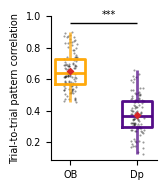

In [10]:
from catrace.visualize import plot_boxplot_with_significance
# Define parameters for the plot
xname = 'region'
yname = 'value'
if metric == 'pattern_correlation':
    ylabel = 'Trial-to-trial pattern correlation'
elif metric == 'cosine':
    ylabel = 'Trial-to-trial cosine distance'
else:
    ylabel = metric
test_type = 'pairwise'
ref_key = 'OB'  # Use 'OB' as the reference category
figsize = (2, 2)
ylim = None
hline_y = 0
show_ns = True
pvalue_marker_xoffset = 0.01

# Plot the boxplot with significance annotations
fig, ax = plot_boxplot_with_significance(datadf, xname, yname, ylabel,
                                         test_results, test_type=test_type, 
                                         ref_key=ref_key, figsize=figsize, 
                                         ylim=ylim, hline_y=None, 
                                         show_ns=show_ns, 
                                         pvalue_marker_xoffset=pvalue_marker_xoffset,
                                         pvalue_marker_fontsize=7,
                                         box_colors=['orange', 'indigo'],
                                         x_order=['OB', 'Dp'],
                                         box_linewidth=2.0,
                                         mean_marker_size=2,
                                         strip_size=1.5,
                                         )

# y label font size
ax.yaxis.label.set_size(7)

fig_name = f'trial_to_trial_{metric}_boxplot'
fig.savefig(pjoin(fig_dir, f'{fig_name}.pdf'))

In [11]:
# Print mean and std in Dp and in OB
# mean with two decimal places
print(f'Dp: {flattened_dp["value"].mean():.2f} ± {flattened_dp["value"].std():.2f}')
print(f'OB: {flattened_ob["value"].mean():.2f} ± {flattened_ob["value"].std():.2f}')


Dp: 0.38 ± 0.12
OB: 0.66 ± 0.12
